# **Training Models with Transfer Learning**

In this notebook, classification models are trained using transfer learning with the goal of differentiating between second and third degree burns. To do this, the pre-trained MobileNetV2, VGG16, and ResNet50 architectures are used. These models were originally trained on ImageNet, allowing their learned representations to be reused and adapted to our problem with a smaller dataset.

In [1]:
import pickle
from keras import models

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2, VGG16, ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tools import load_images_with_labels, evaluate_model, save_metrics_to_csv

## Load data

In [2]:
#Image dimensions for transfer learning models
width = 224
height = 224

#Path where images are stored and organized by class
path = '../data/burn_images/'

In [3]:
#Load images and their corresponding labels (RGB images for transfer learning models)
X, y = load_images_with_labels(path=path, channels='bgr', width=width, height=height)

In [4]:
#Split the dataset into 80% training and 20% validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)

print('Shape of X_train:', X_train.shape)
print('Shape of X_val:', X_val.shape)
print('Shape of y_train:', y_train.shape)
print('Shape of y_val:', y_val.shape)

Shape of X_train: (180, 224, 224, 3)
Shape of X_val: (45, 224, 224, 3)
Shape of y_train: (180,)
Shape of y_val: (45,)


## Callbacks for training all models

In [5]:
#Stop training when the model stops improving
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10, #Wait 10 epochs without improvement before stopping
    restore_best_weights=True #Restore weights from the epoch with the best val_loss
)

#Reduce the learning rate when the model stagnates
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, #Reduce the learning rate by half when there is no improvement
    patience=5, #Wait 5 epochs without improvement before reducing
    min_lr=1e-7 #Minimum allowed learning rate
)

## MobileNetV2

In [6]:
#MobileNetV2 specific preprocessing function (adjusts pixel values to the range expected by the model)
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

#Normalize images
X_train_norm = preprocess_input(X_train.copy())
X_val_norm = preprocess_input(X_val.copy())

In [7]:
#Load the MobileNetV2 model
mobilenetv2 = MobileNetV2(input_shape=(height, width, 3),
                          include_top=False, #Remove the original classification layer to adapt it to our problem
                          weights='imagenet')

#Freeze the base model layers to train only the new classification head
for layer in mobilenetv2.layers:
    layer.trainable = False

In [8]:
#Add the custom classification head
x = GlobalAveragePooling2D()(mobilenetv2.output)
x = Dropout(rate=0.4)(x)
output = Dense(units=1, activation='sigmoid')(x)

mobilenetv2_model = Model(inputs=mobilenetv2.input, outputs=output)

In [ ]:
#Display the final model architecture
mobilenetv2_model.summary()

In [9]:
#Compile the model
mobilenetv2_model.compile(loss='binary_crossentropy', 
                          optimizer='adam', 
                          metrics=['accuracy'])

In [10]:
#Model training
history = mobilenetv2_model.fit(X_train_norm, y_train, 
                                epochs=100, batch_size=32, 
                                validation_data=(X_val_norm, y_val),
                                callbacks=[early_stopping, reduce_lr])

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 879ms/step - accuracy: 0.5557 - loss: 0.8377 - val_accuracy: 0.4667 - val_loss: 0.7754 - learning_rate: 0.0010
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 605ms/step - accuracy: 0.5278 - loss: 0.8391 - val_accuracy: 0.5333 - val_loss: 0.6244 - learning_rate: 0.0010
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 569ms/step - accuracy: 0.6821 - loss: 0.5827 - val_accuracy: 0.8889 - val_loss: 0.4220 - learning_rate: 0.0010
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 557ms/step - accuracy: 0.7005 - loss: 0.5106 - val_accuracy: 0.8889 - val_loss: 0.3755 - learning_rate: 0.0010
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 552ms/step - accuracy: 0.7996 - loss: 0.4687 - val_accuracy: 0.8667 - val_loss: 0.3819 - learning_rate: 0.0010
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 544ms/step - accuracy: 0.8394 - loss: 0.4013 - val_accuracy: 0.8000 - val_loss: 0.3833 - learning_rate: 0.0010
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 553ms/step - accuracy: 0.8822 - loss: 0.3242 - val_acc

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 601ms/step


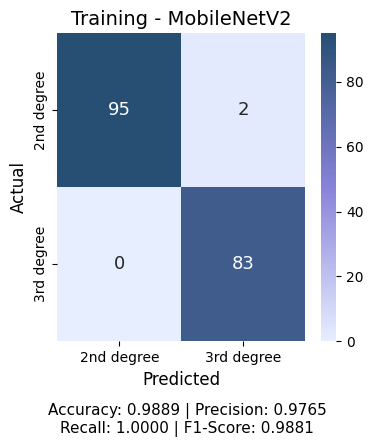

In [11]:
#Evaluation metrics on the training set
evaluate_model(mobilenetv2_model, X_train_norm, y_train, dataset='Training - MobileNetV2')

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step


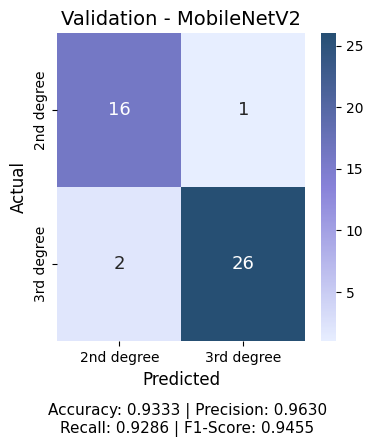

In [12]:
#Evaluation metrics on the validation set
evaluate_model(mobilenetv2_model, X_val_norm, y_val, dataset='Validation - MobileNetV2')

In [13]:
#Save evaluation metrics to a CSV file
save_metrics_to_csv(mobilenetv2_model, X_train_norm, y_train, 'MobileNetV2', 'train', '../data/results/model_metrics.csv')
save_metrics_to_csv(mobilenetv2_model, X_val_norm, y_val, 'MobileNetV2', 'val', '../data/results/model_metrics.csv')

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 522ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 240ms/step


In [14]:
#Save the trained model in .keras format
models.save_model(mobilenetv2_model, '../models/mobilenetv2/mobilenetv2.keras')

#Save training history
with open('../models/mobilenetv2/mobilenetv2_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

## VGG16

In [6]:
#VGG16 specific preprocessing function (adjusts pixel values to the range expected by the model)
from tensorflow.keras.applications.vgg16 import preprocess_input

#Normalize images
X_train_norm = preprocess_input(X_train.copy())
X_val_norm = preprocess_input(X_val.copy())

In [7]:
#Load the VGG16 model
vgg16 = VGG16(input_shape=(height, width, 3),
              include_top=False, #Remove the original classification layer to adapt it to our problem
              weights='imagenet')

#Freeze the base model layers to train only the new classification head
for layer in vgg16.layers:
    layer.trainable = False

In [8]:
#Add the custom classification head
x = GlobalAveragePooling2D()(vgg16.output) 
x = Dropout(rate=0.4)(x)
output = Dense(units=1, activation='sigmoid')(x)

vgg16_model = Model(inputs=vgg16.input, outputs=output)

In [ ]:
#Display the final model architecture
vgg16_model.summary()

In [9]:
#Compile the model
vgg16_model.compile(loss='binary_crossentropy', 
                    optimizer='adam', 
                    metrics=['accuracy'])

In [10]:
#Model training
history = vgg16_model.fit(X_train_norm, y_train, 
                          epochs=100, batch_size=32, 
                          validation_data=(X_val_norm, y_val),
                          callbacks=[early_stopping, reduce_lr])

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.5359 - loss: 2.4122 - val_accuracy: 0.6222 - val_loss: 0.9556 - learning_rate: 0.0010
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.5523 - loss: 1.7039 - val_accuracy: 0.7556 - val_loss: 0.6540 - learning_rate: 0.0010
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.5611 - loss: 1.5860 - val_accuracy: 0.8222 - val_loss: 0.5980 - learning_rate: 0.0010
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.6130 - loss: 1.3276 - val_accuracy: 0.7778 - val_loss: 0.6096 - learning_rate: 0.0010
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.5774 - loss: 1.6244 - val_accuracy: 0.7556 - val_loss: 0.5856 - learning_rate: 0.0010
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.6455 - loss: 1.2490 - val_accuracy: 0.8000 - val_loss: 0.5449 - learning_rate: 0.0010
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.6789 - loss: 1.1275 - val_accuracy: 0.8000 

6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step


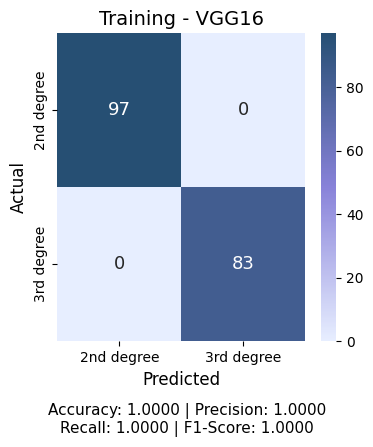

In [11]:
#Evaluation metrics on the training set
evaluate_model(vgg16_model, X_train_norm, y_train, dataset='Training - VGG16')

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 994ms/step


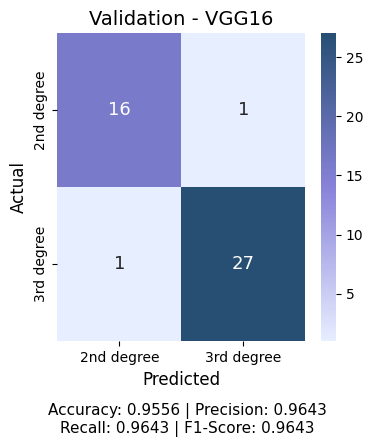

In [12]:
#Evaluation metrics on the validation set
evaluate_model(vgg16_model, X_val_norm, y_val, dataset='Validation - VGG16')

In [13]:
#Save evaluation metrics to a CSV file
save_metrics_to_csv(vgg16_model, X_train_norm, y_train, 'VGG16', 'train', '../data/results/model_metrics.csv')
save_metrics_to_csv(vgg16_model, X_val_norm, y_val, 'VGG16', 'val', '../data/results/model_metrics.csv')

6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step   


In [14]:
#Save the trained model in .keras format
models.save_model(vgg16_model, '../models/vgg16/vgg16.keras')

#Save training history
with open('../models/vgg16/vgg16_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

## ResNet50

In [6]:
#ResNet50 specific preprocessing function (adjusts pixel values to the range expected by the model)
from tensorflow.keras.applications.resnet50 import preprocess_input

#Normalize images
X_train_norm = preprocess_input(X_train.copy())
X_val_norm = preprocess_input(X_val.copy())

In [7]:
#Load the ResNet50 model
resnet50 = ResNet50(input_shape=(height, width, 3),
                    include_top=False, #Remove the original classification layer to adapt it to our problem
                    weights='imagenet')

#Freeze the base model layers to train only the new classification head
for layer in resnet50.layers:
    layer.trainable = False

In [8]:
#Add the custom classification head
x = GlobalAveragePooling2D()(resnet50.output)
x = Dropout(rate=0.4)(x)
output = Dense(units=1, activation='sigmoid')(x)

resnet50_model = Model(inputs=resnet50.input, outputs=output)

In [ ]:
#Display the final model architecture
resnet50_model.summary()

In [9]:
#Compile the model
resnet50_model.compile(loss='binary_crossentropy', 
                       optimizer='adam', 
                       metrics=['accuracy'])

In [10]:
#Model training
history = resnet50_model.fit(X_train_norm, y_train, 
                            epochs=100, batch_size=32, 
                            validation_data=(X_val_norm, y_val),
                            callbacks=[early_stopping, reduce_lr])

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.5228 - loss: 0.9007 - val_accuracy: 0.7333 - val_loss: 0.5897 - learning_rate: 0.0010
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.6469 - loss: 0.6462 - val_accuracy: 0.8222 - val_loss: 0.4746 - learning_rate: 0.0010
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.7832 - loss: 0.4782 - val_accuracy: 0.9111 - val_loss: 0.3540 - learning_rate: 0.0010
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.8257 - loss: 0.3776 - val_accuracy: 0.9333 - val_loss: 0.3133 - learning_rate: 0.0010
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.8426 - loss: 0.3335 - val_accuracy: 0.9333 - val_loss: 0.2571 - learning_rate: 0.0010
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.8538 - loss: 0.3457 - val_accuracy: 0.9333 - val_loss: 0.2300 - learning_rate: 0.0010
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.9180 - loss: 0.2185 - val_accuracy: 0.9778 - val

6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step


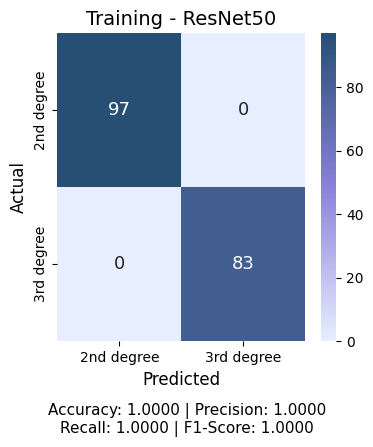

In [11]:
#Evaluation metrics on the training set
evaluate_model(resnet50_model, X_train_norm, y_train, dataset='Training - ResNet50')

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 510ms/step


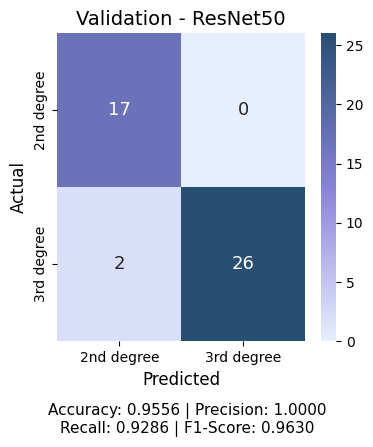

In [12]:
#Evaluation metrics on the validation set
evaluate_model(resnet50_model, X_val_norm, y_val, dataset='Validation - ResNet50')

In [13]:
#Save evaluation metrics to a CSV file
save_metrics_to_csv(resnet50_model, X_train_norm, y_train, 'ResNet50', 'train', '../data/results/model_metrics.csv')
save_metrics_to_csv(resnet50_model, X_val_norm, y_val, 'ResNet50', 'val', '../data/results/model_metrics.csv')

6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 643ms/step


In [14]:
#Save the trained model in .keras format
models.save_model(resnet50_model, '../models/resnet50/resnet50.keras')

#Save training history
with open('../models/resnet50/resnet50_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)